# Hyperplaying
Here, we play with the parameters.

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Whole pipeline
We group all the operations of the pipeline in a single function, so that we can easily play with the parameters.

In [2]:
from load_data import load_chord_data, load_key_data, all_composers

from gensim.models import Word2Vec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from reduce_dim import reduce_dim_keyed_vec

from visual import visual_reduced_chord_vectors

In [16]:
def all_in_one(composers, key_mode='both', 
               min_count=10, size=20, window=7, sg=1, 
               dimred_method='PCA', n_red_components=2, comps_to_keep=[0,1], 
               draw_graph=True, plot_title='', figsize=(15,15), dpi=250, remove_key_mode=False, chord_types_to_label=[],
               chord_types_not_to_label=[], label_size=6, marker_map={'MAJOR':'o', 'MINOR':'s', 'UNSPEC':'D'}, marker_size=40, 
               colour_map={'I':'blue', 'II':'yellow', 'III':'green', 'IV':'purple', 'V':'red', 'VI':'orange', 'VII':'pink'}, 
               fig_name='figures/sarno.png', 
               chord_types_to_print_sim=[], chord_types_not_to_print_sim=[], topn=4):
    '''
    Synthesises the whole pipeline in a single function. Helps experimenting with the parameters.
    
    Input.  composers: the list of the file names corresponding to the composers considered.
            key_mode: the key mode to restrict to, can be 'major', 'minor' or 'both'.
            
            min_count: minimum frequency of chords considered for training.
            size: the dimension of the embedding space.
            window: the context width.
            sg: the algorithm. 0 for CBOW, 1 for skip-gram.
            
            dimred_method: the method used for dimentionality reduction: 'PCA', 'TSNE', or 'Isomap'.
            n_red_components: the number of components to reduce to.
            comps_to_keep: the components to keep for plotting.
            
            draw_graph: flag signalling whether to scatter the dimensionality-reduced word vectors.
            plot_title: title of the plot.
            figsize: the size of the graph.
            dpi: the dot-per-inch of the graph.
            remove_key_mode: flag signalling whether to remove the key mode indication from the chord.
            chord_types_to_label: list containing substrings. Chords containing any of those substring will have a label 
                                  with the chord name near the point in the graph.
            chord_types_not_to_label: list containing substrings. Chords containing any of those substring will not have 
                                      the label. Overrides chord_types_to_label.
            label_size: the font size of the labels.
            marker_map: dictionary mapping key mode ('MAJOR'/'MINOR'/'UNSPEC') to marker.
            marker_size: the size of each marker.
            colour_map: dictionary mapping each root ('I' through 'VII') to a colour string.
            fig_name: name of the file to save the plot to.
            
            chord_types_to_print_sim: list containing substrings. Chords containing any of those substring will have a label 
                                  with the chord name near the point in the graph.
            chord_types_not_to_print_sim: list containing substrings. Chords containing any of those substring will not have 
                                      the label. Overrides chord_types_to_print_sim.
            top: the number of similar chords to print.
    
    Output. model: the trained model.
    '''
    
    # Load chords
    chords = load_chord_data(composers, key_mode)

    # Train model
    model = Word2Vec(chords, min_count=min_count, size=size, window=window, sg=sg, iter=n_iter_train)
    
    # Reduce dimensionality
    wv_red = None 
    if dimred_method=='PCA':
        pca = PCA(n_components=n_red_components)
        wv_red = reduce_dim_keyed_vec(model.wv, pca.fit_transform, comps_to_keep=comps_to_keep)
    elif dimred_method=='TSNE':
        tsne = TSNE(n_components=n_red_components)
        wv_red = reduce_dim_keyed_vec(model.wv, tsne.fit_transform, comps_to_keep=comps_to_keep)
    elif dimred_method=='Isomap':
        isomap = Isomap(n_components=n_red_components)
        wv_red = reduce_dim_keyed_vec(model.wv, isomap.fit_transform, comps_to_keep=comps_to_keep)
    
    # Draw graph, if required
    if draw_graph:
        visual_reduced_chord_vectors(wv_red, dimred_method=dimred_method, plot_title=plot_title, figsize=figsize, dpi=dpi, 
                                     remove_key_mode=remove_key_mode, chord_types_to_label=chord_types_to_label, 
                                     chord_types_not_to_label=chord_types_not_to_label, label_size=label_size, 
                                     marker_map=marker_map, marker_size=marker_size, colour_map=colour_map, 
                                     fig_name=fig_name)
    
    # For each required chord, print the 'topn' most similar chords in the embedding space
    for chord in  sorted(model.wv.vocab.keys()):
        # Skip if current chord contains a forbidden substring, or if it contains none of the allowed substrings
        forbidden = any(chord_type in chord for chord_type in chord_types_not_to_print_sim)
        required = any(chord_type in chord for chord_type in chord_types_to_print_sim)
        if forbidden or not required:
            continue
        similar=':'
        for neighbour, similarity in model.wv.most_similar(chord, topn=topn):
            similar +=f' ({neighbour}, {similarity:.3f}),'
        print(chord + similar)

## Play around with parameters

Fix `sg = 0`, `min_count = 10`, `size = 20`; vary `window`

In [21]:
# Fixed parameters
sg = 1
min_count = 10
size = 20

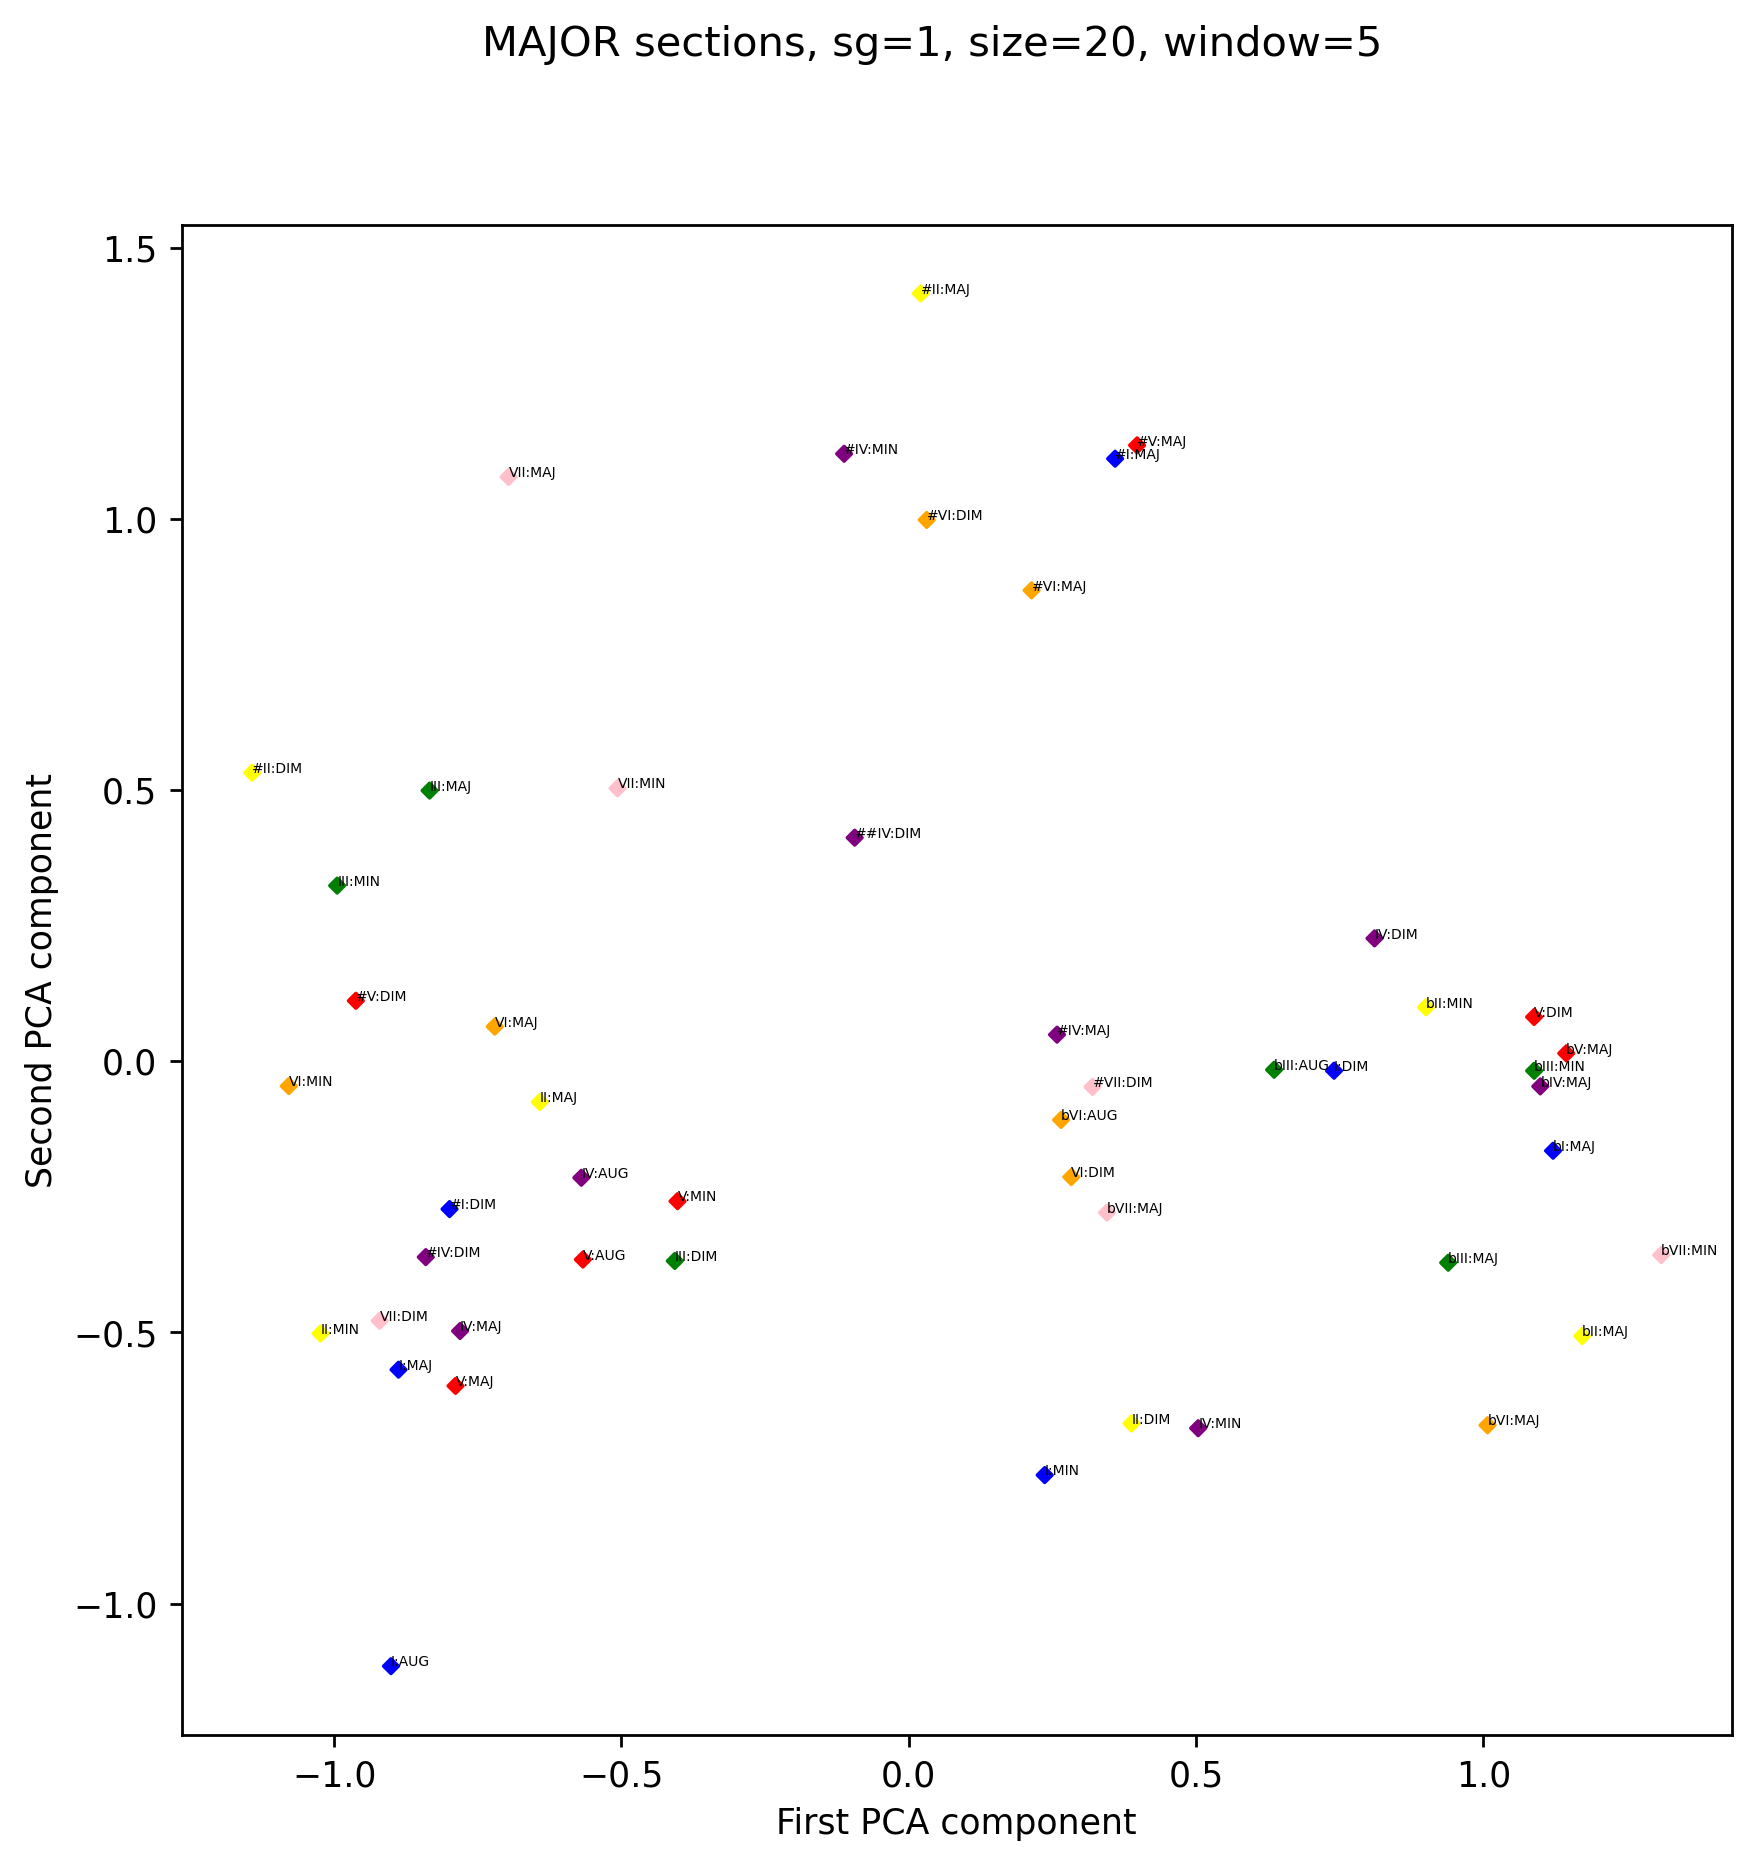

In [31]:
window = 5

# Draw graph
all_in_one(all_composers, key_mode='major', min_count=min_count, size=size, window=window, sg=sg,
           dimred_method='PCA', draw_graph=True, chord_types_to_label=[''], figsize=(8, 8), marker_size=9, label_size=4, 
           plot_title='MAJOR sections, sg=1, size=20, window=5')

# THERE APPEARS TO BE A HIGH VARIANCE IN THIS GRAPH

In [ ]:
# Print similarities
all_in_one(all_composers, key_mode='major', min_count=min_count, size=size, window=window, sg=sg,
           dimred_method='TSNE', draw_graph=False, chord_types_to_print_sim=[':'], 
           chord_types_not_to_print_sim=[])

# THESE SIMILARITIES DO NOT SEEM TO MAKE MUCH SENSE

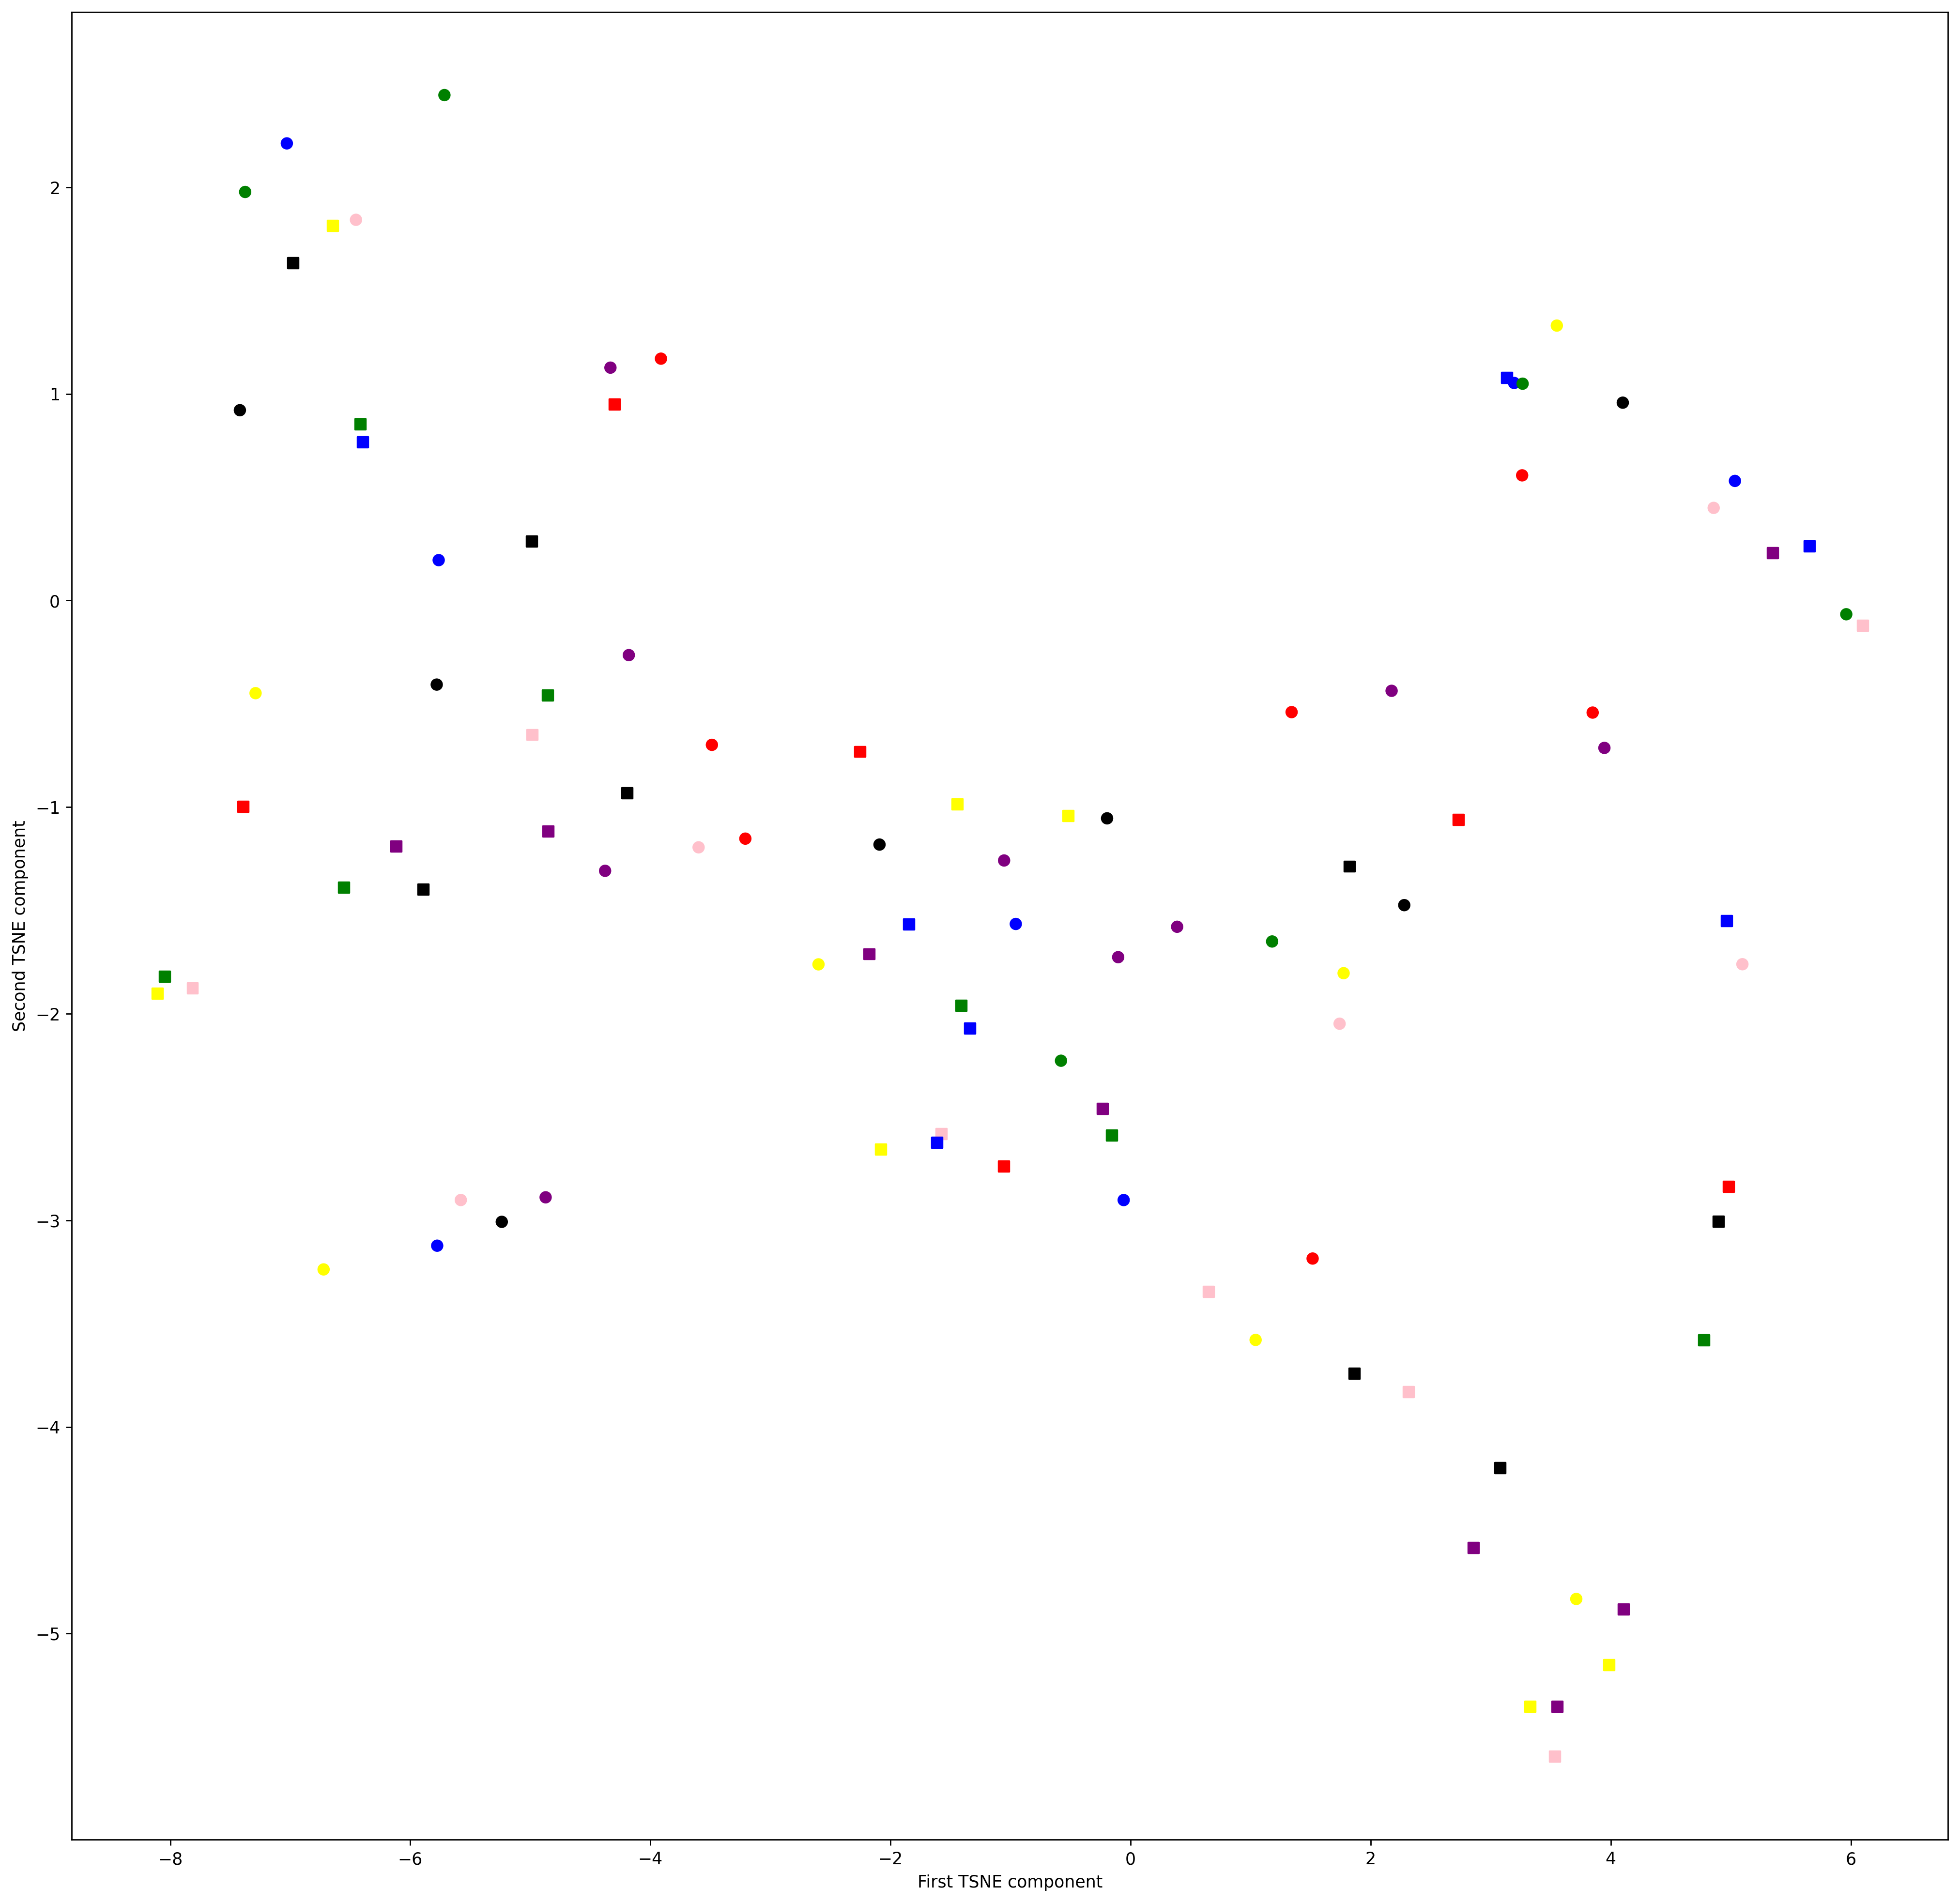

In [31]:
# Window = 5
window = 5

# Draw graph
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
               dimred_method='TSNE', draw_graph=True)

# THERE APPEARS TO BE A FAIRLY HIGH VARIANCE IN THIS GRAPH

In [30]:
# Print similarities
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
           dimred_method='TSNE', draw_graph=False, chord_types_to_print_sim=[';'], 
           chord_types_not_to_print_sim=['b', '#'])

# THESE SIMILARITIES SEEM A BIT MORE REASONABLE

MAJOR;I:AUG: (MAJOR;VII:DIM, 0.956), (MAJOR;I:MAJ, 0.939), (MAJOR;IV:MAJ, 0.931), (MAJOR;V:MAJ, 0.923),
MAJOR;I:DIM: (MAJOR;V:DIM, 0.982), (MAJOR;bVII:MIN, 0.978), (MAJOR;VI:DIM, 0.973), (MAJOR;#IV:MAJ, 0.969),
MAJOR;I:MAJ: (MAJOR;V:MAJ, 0.968), (MAJOR;VII:DIM, 0.958), (MAJOR;IV:MAJ, 0.957), (MAJOR;I:AUG, 0.939),
MAJOR;I:MIN: (MAJOR;II:DIM, 0.976), (MAJOR;#IV:MAJ, 0.974), (MAJOR;IV:MIN, 0.971), (MAJOR;VI:DIM, 0.971),
MAJOR;II:DIM: (MAJOR;I:MIN, 0.976), (MAJOR;IV:MIN, 0.971), (MAJOR;#IV:MAJ, 0.970), (MAJOR;I:DIM, 0.953),
MAJOR;II:MAJ: (MAJOR;#IV:DIM, 0.954), (MAJOR;VII:MIN, 0.946), (MAJOR;##IV:DIM, 0.936), (MAJOR;#I:DIM, 0.913),
MAJOR;II:MIN: (MAJOR;IV:MAJ, 0.965), (MAJOR;V:MAJ, 0.911), (MAJOR;I:MAJ, 0.908), (MAJOR;VII:DIM, 0.904),
MAJOR;III:DIM: (MAJOR;V:MIN, 0.971), (MAJOR;bVII:MAJ, 0.958), (MAJOR;#I:DIM, 0.913), (MAJOR;##IV:DIM, 0.903),
MAJOR;III:MAJ: (MAJOR;#V:DIM, 0.966), (MAJOR;#II:MAJ, 0.918), (MAJOR;VII:MAJ, 0.902), (MAJOR;#II:DIM, 0.873),
MAJOR;III:MIN: (MAJOR;#II:DIM, 0.935), 

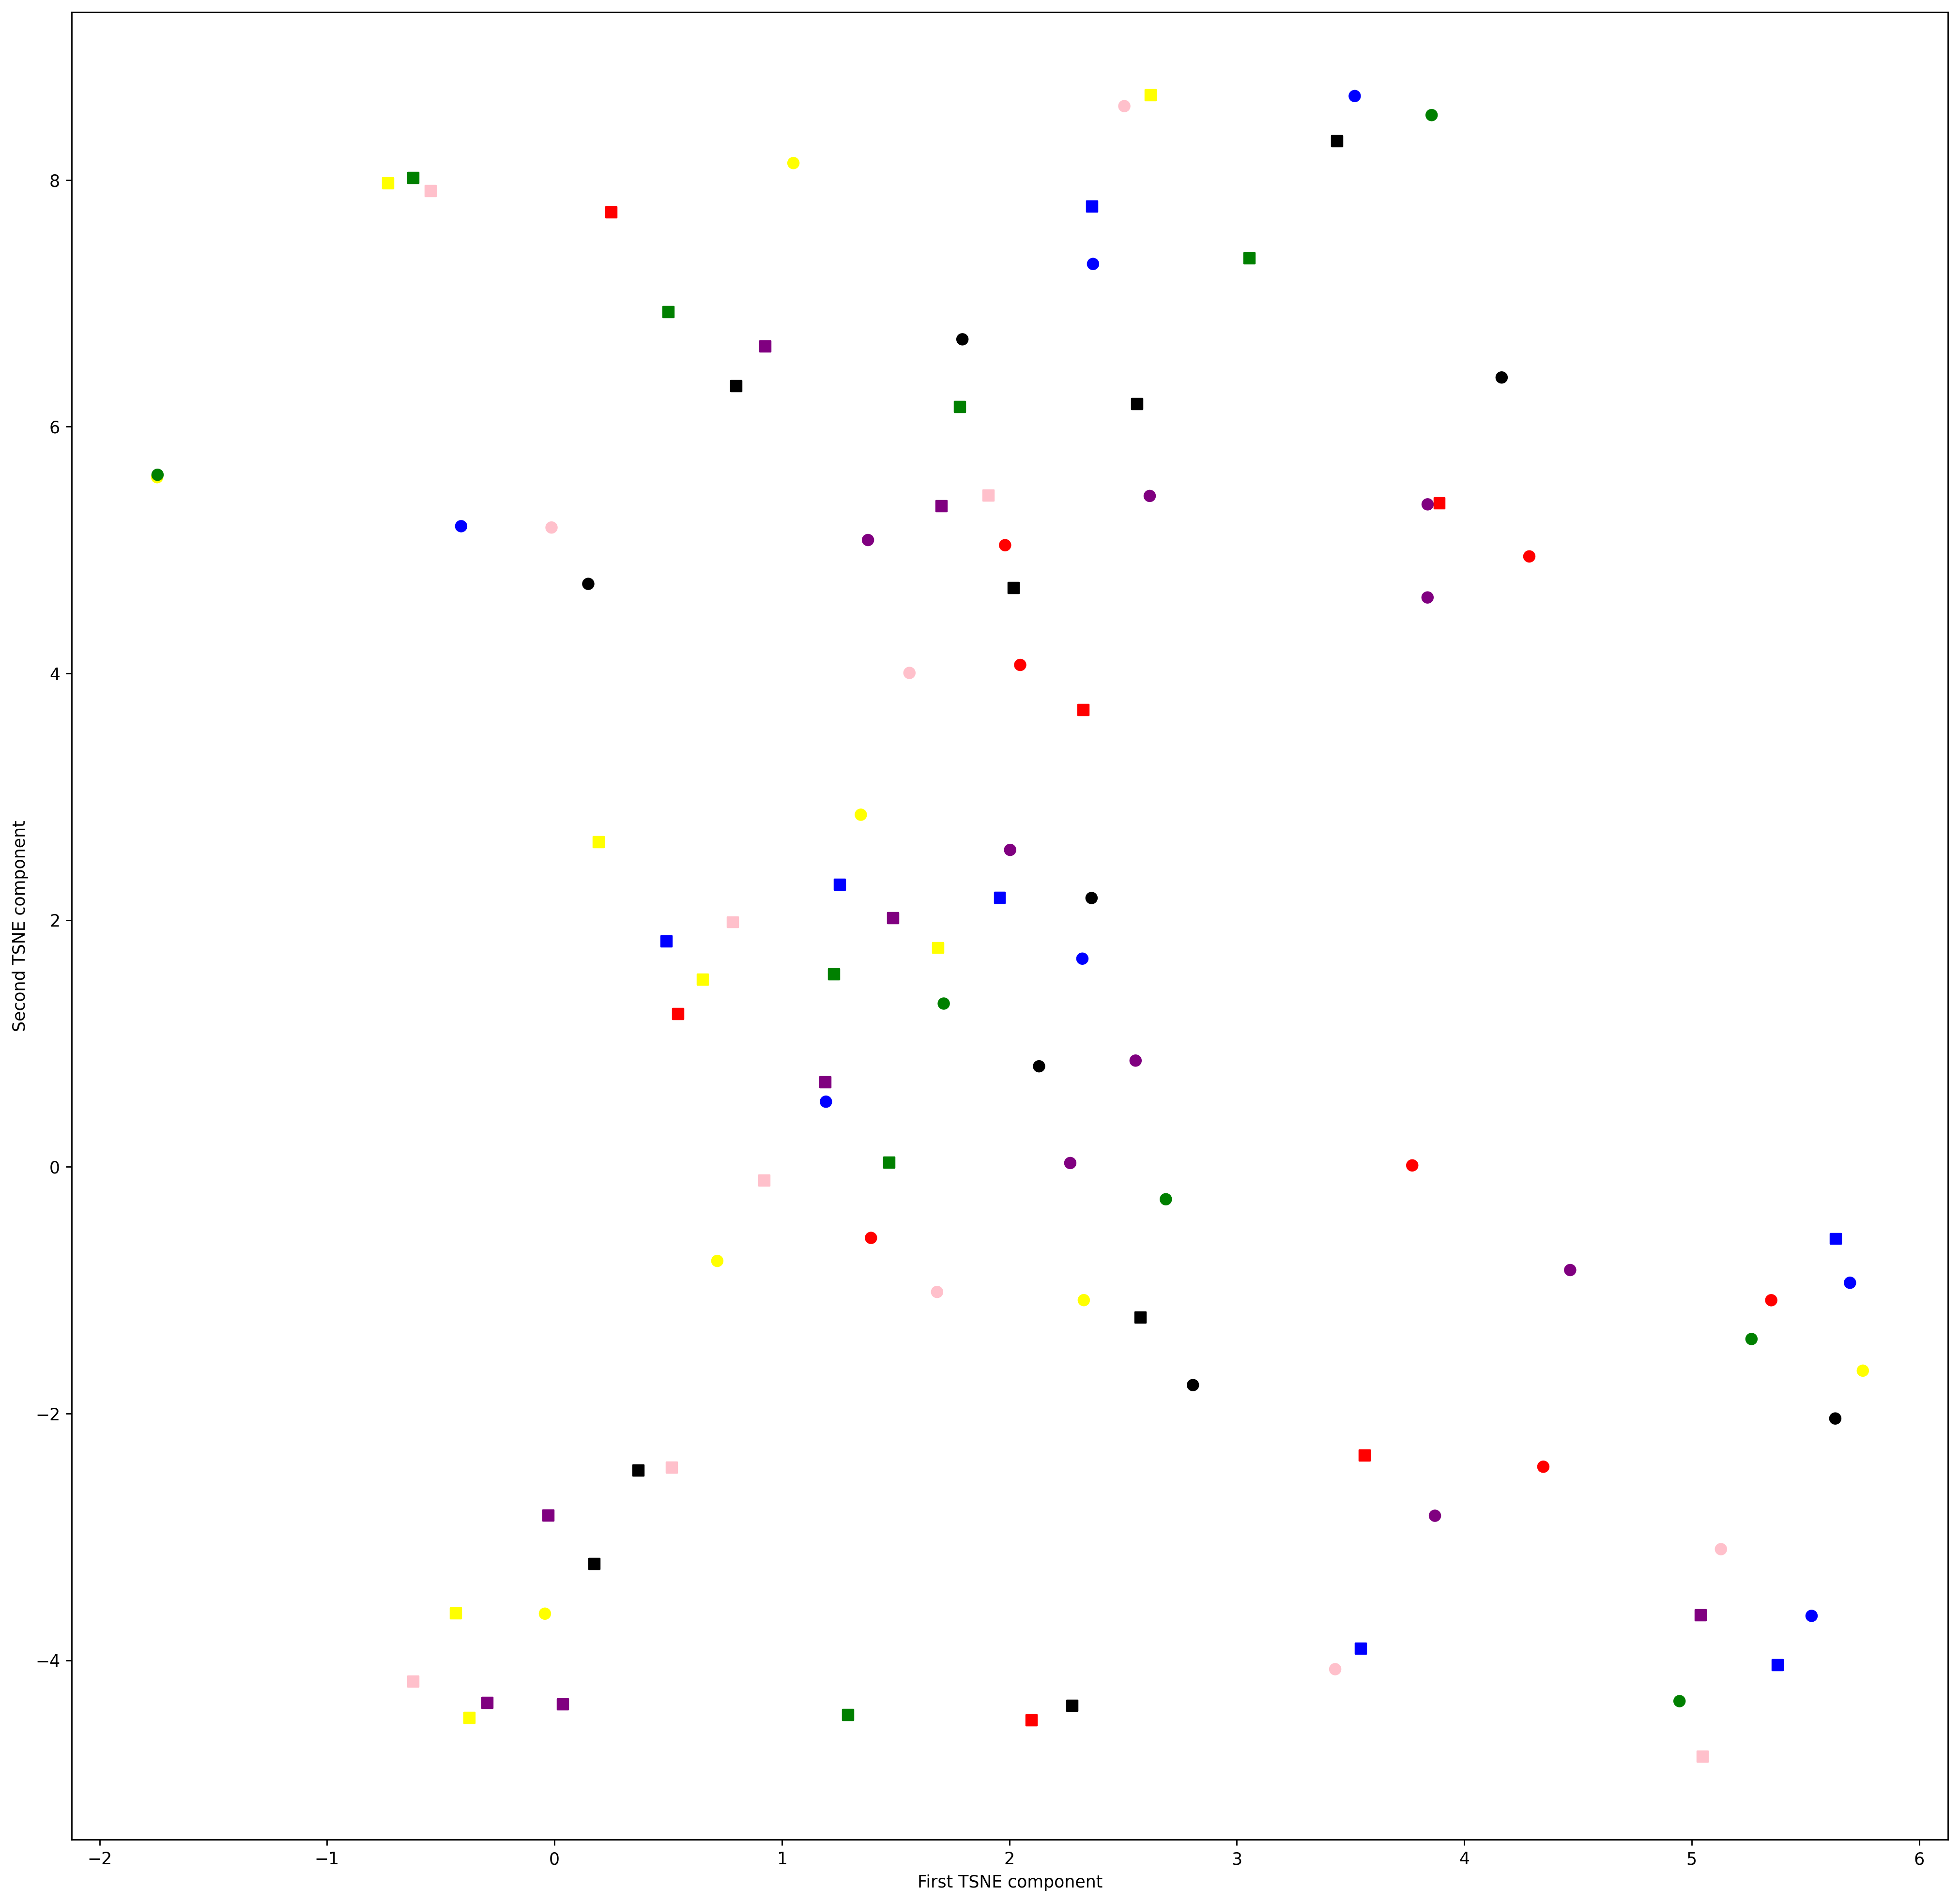

In [34]:
# Window = 10
window = 10

# Draw graph
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
               dimred_method='TSNE', draw_graph=True)

# THERE APPEARS TO BE A FAIRLY HIGH VARIANCE IN THIS GRAPH

In [40]:
# Print similarities
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
           dimred_method='TSNE', draw_graph=False, chord_types_to_print_sim=[';'], 
           chord_types_not_to_print_sim=['b', '#'])

# THESE SIMILARITIES SEEM REASONABLE

MAJOR;I:AUG: (MAJOR;V:AUG, 0.942), (MAJOR;IV:AUG, 0.868), (MAJOR;I:MAJ, 0.833), (MAJOR;VII:DIM, 0.830),
MAJOR;I:DIM: (MAJOR;bIII:MIN, 0.984), (MAJOR;bIII:AUG, 0.982), (MAJOR;IV:DIM, 0.978), (MAJOR;V:DIM, 0.969),
MAJOR;I:MAJ: (MAJOR;#IV:DIM, 0.961), (MAJOR;VII:DIM, 0.960), (MAJOR;II:MIN, 0.957), (MAJOR;V:MAJ, 0.951),
MAJOR;I:MIN: (MAJOR;#VII:DIM, 0.905), (MAJOR;IV:MIN, 0.903), (MAJOR;VI:DIM, 0.887), (MAJOR;bIII:AUG, 0.883),
MAJOR;II:DIM: (MAJOR;#VII:DIM, 0.887), (MAJOR;bVI:AUG, 0.887), (MAJOR;I:DIM, 0.886), (MAJOR;VI:DIM, 0.875),
MAJOR;II:MAJ: (MAJOR;#IV:DIM, 0.958), (MAJOR;IV:AUG, 0.932), (MAJOR;VI:MIN, 0.928), (MAJOR;VII:MIN, 0.917),
MAJOR;II:MIN: (MAJOR;IV:MAJ, 0.958), (MAJOR;VII:DIM, 0.957), (MAJOR;I:MAJ, 0.957), (MAJOR;V:MAJ, 0.943),
MAJOR;III:DIM: (MAJOR;bVII:MAJ, 0.939), (MAJOR;V:MIN, 0.938), (MAJOR;#I:DIM, 0.923), (MAJOR;VI:MAJ, 0.919),
MAJOR;III:MAJ: (MAJOR;#V:DIM, 0.947), (MAJOR;VI:MIN, 0.903), (MAJOR;II:MAJ, 0.892), (MAJOR;IV:AUG, 0.892),
MAJOR;III:MIN: (MAJOR;VII:MIN, 0.928)

Fix `sg = 1`, `min_count = 10`, `size = 20`, `window = 10`

In [37]:
# Fixed parameters
sg = 1
min_count = 10
size = 20
window = 10

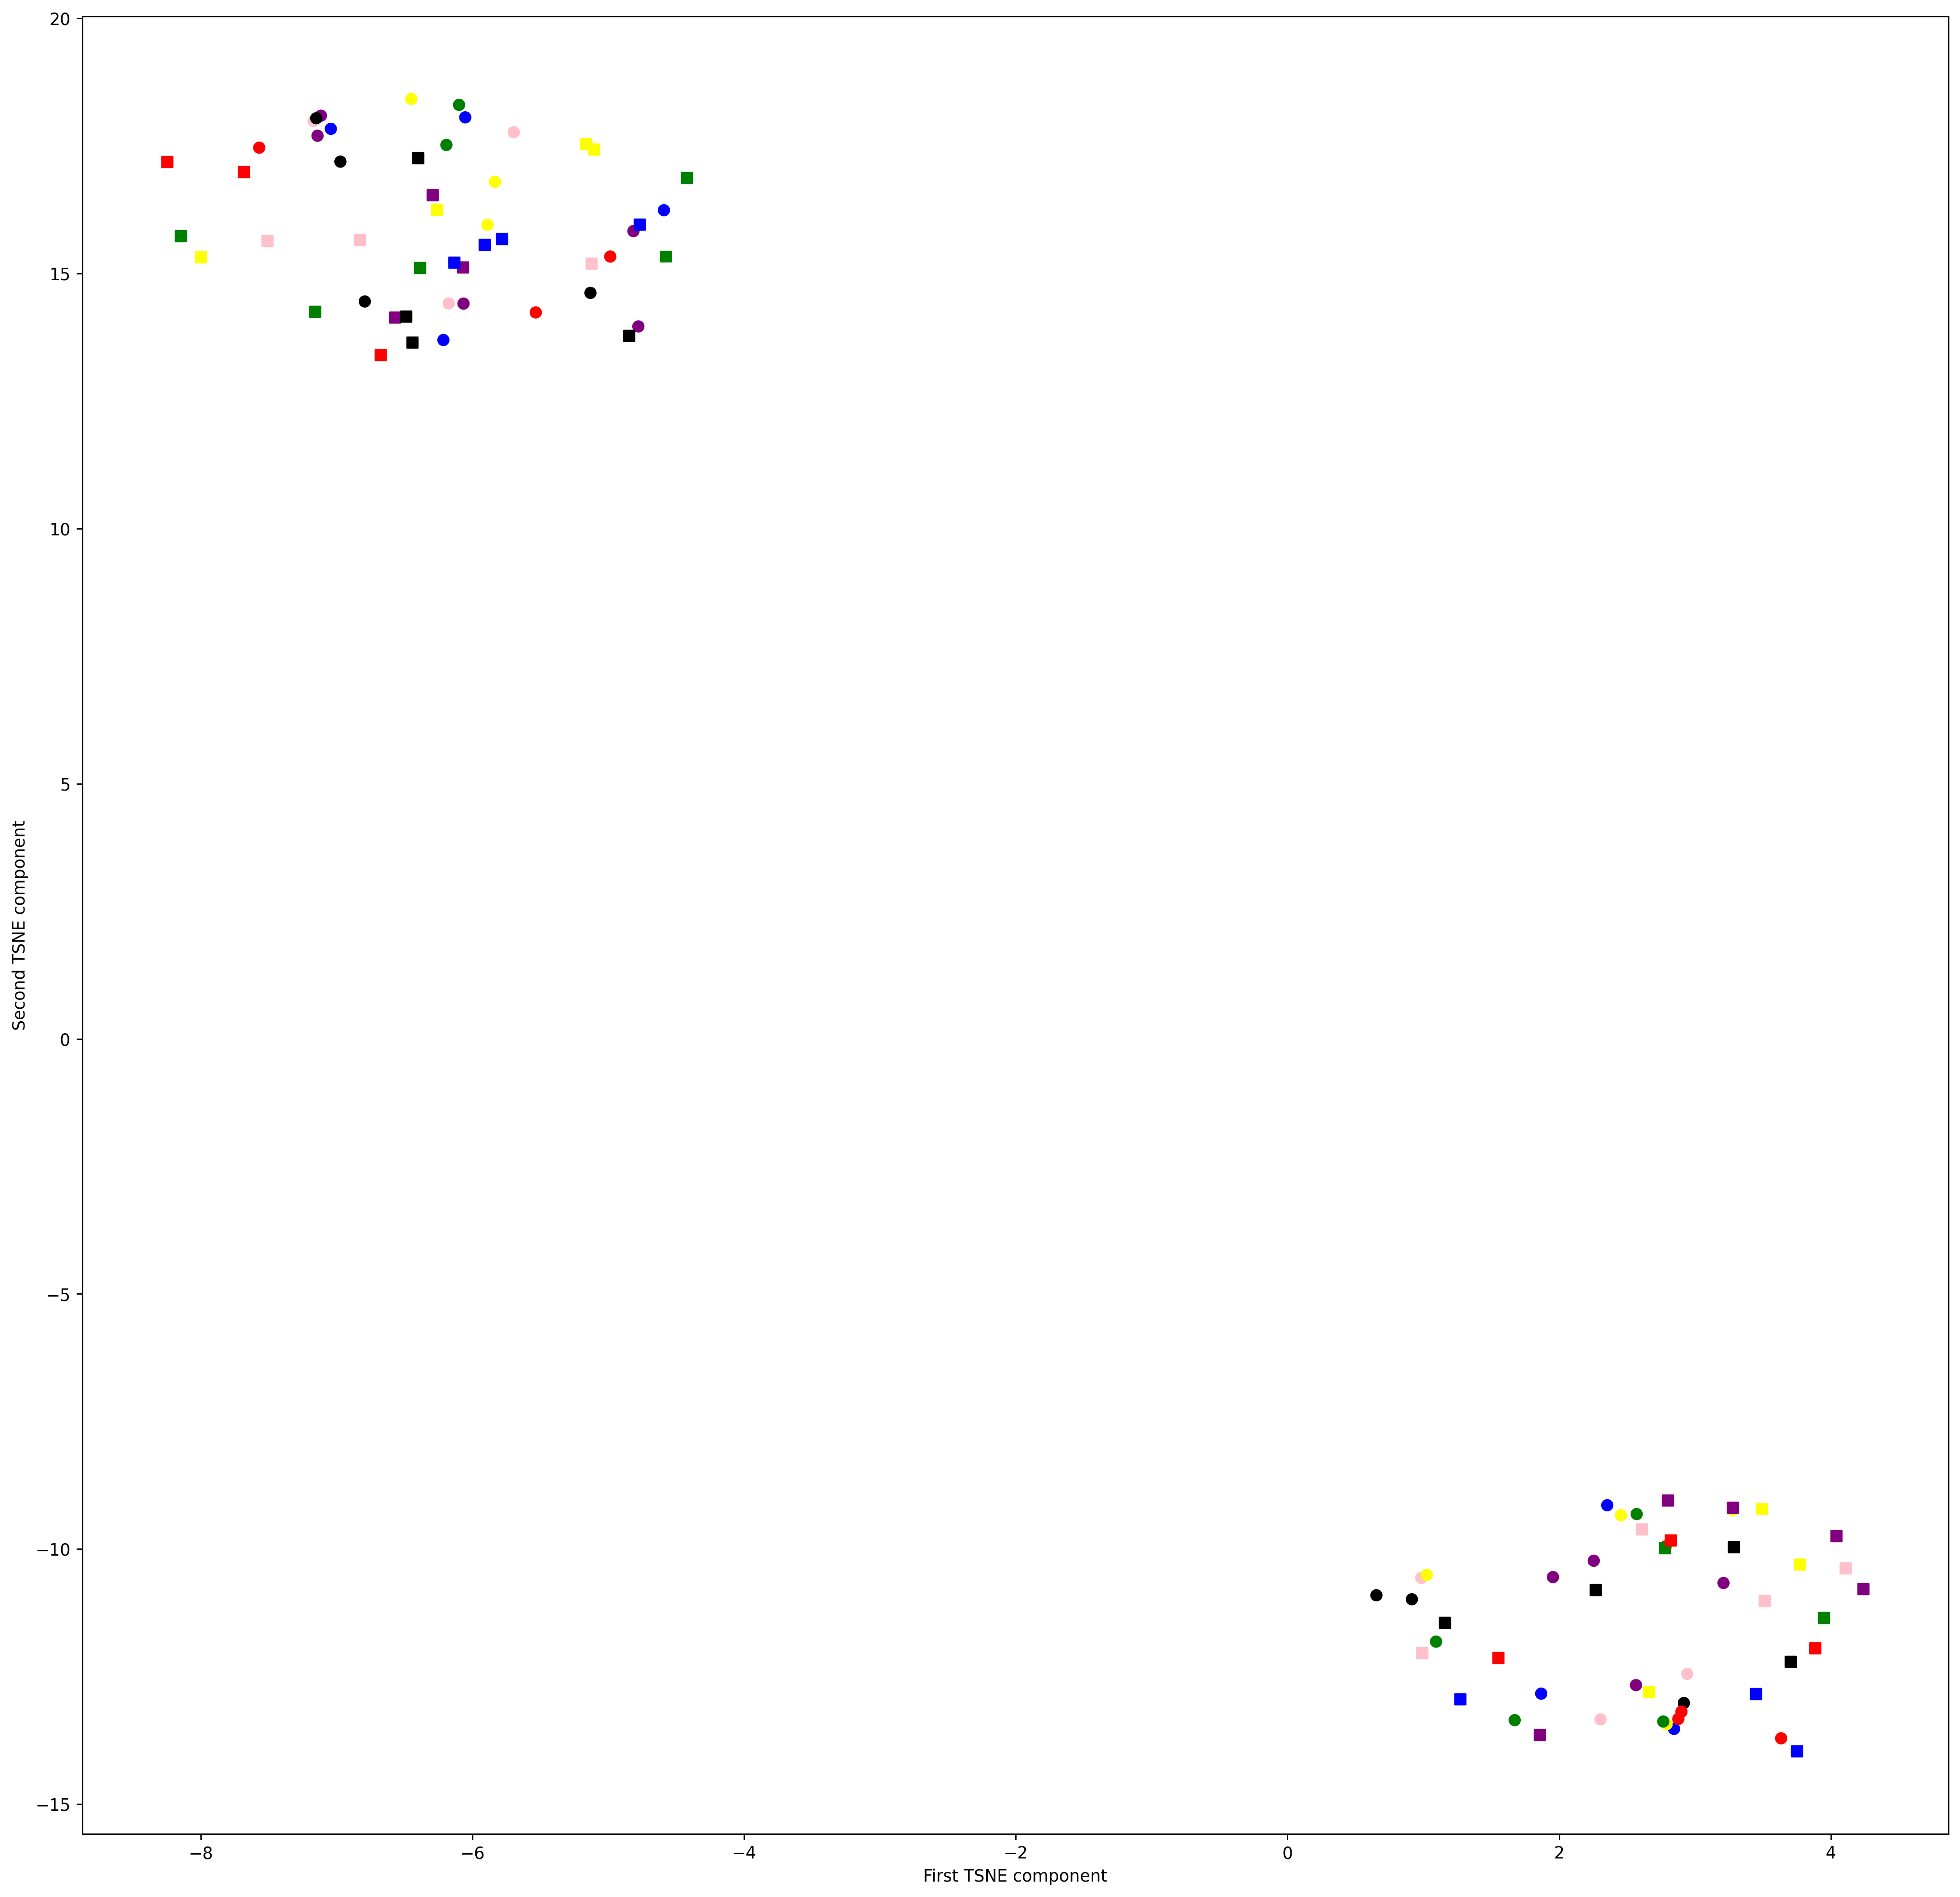

In [48]:
# Draw graph
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
               dimred_method='TSNE', draw_graph=True)

# THERE APPEARS TO BE A FAIRLY HIGH VARIANCE IN THIS GRAPH

In [41]:
# Print similarities
all_in_one(all_composers, key_mode='both', min_count=min_count, size=size, window=window, sg=sg,
           dimred_method='TSNE', draw_graph=False, chord_types_to_print_sim=[';'], 
           chord_types_not_to_print_sim=['b', '#'])

# THESE SIMILARITIES SEEM REASONABLE

MAJOR;I:AUG: (MAJOR;V:AUG, 0.962), (MAJOR;IV:AUG, 0.894), (MAJOR;VII:DIM, 0.849), (MAJOR;#IV:DIM, 0.843),
MAJOR;I:DIM: (MAJOR;bIII:MIN, 0.991), (MAJOR;bIII:AUG, 0.991), (MAJOR;IV:DIM, 0.978), (MAJOR;bVII:MIN, 0.975),
MAJOR;I:MAJ: (MAJOR;V:MAJ, 0.958), (MAJOR;VII:DIM, 0.957), (MAJOR;IV:MAJ, 0.948), (MAJOR;II:MIN, 0.946),
MAJOR;I:MIN: (MAJOR;VI:DIM, 0.920), (MAJOR;#VII:DIM, 0.915), (MAJOR;IV:MIN, 0.912), (MAJOR;bIII:MAJ, 0.879),
MAJOR;II:DIM: (MAJOR;IV:MIN, 0.908), (MAJOR;#VII:DIM, 0.887), (MAJOR;I:DIM, 0.885), (MAJOR;bVI:AUG, 0.870),
MAJOR;II:MAJ: (MAJOR;#IV:DIM, 0.957), (MAJOR;VI:MIN, 0.935), (MAJOR;IV:AUG, 0.935), (MAJOR;II:MIN, 0.933),
MAJOR;II:MIN: (MAJOR;IV:MAJ, 0.964), (MAJOR;VII:DIM, 0.962), (MAJOR;V:MAJ, 0.951), (MAJOR;I:MAJ, 0.946),
MAJOR;III:DIM: (MAJOR;bVII:MAJ, 0.930), (MAJOR;VI:MAJ, 0.914), (MAJOR;#I:DIM, 0.910), (MAJOR;V:MIN, 0.906),
MAJOR;III:MAJ: (MAJOR;#V:DIM, 0.965), (MAJOR;VI:MIN, 0.919), (MAJOR;VI:MAJ, 0.883), (MAJOR;II:MAJ, 0.880),
MAJOR;III:MIN: (MAJOR;VII:MIN, 0.9